\begin{equation}
	\begin{aligned}
		V(x) \quad  = \quad \max_{y} \quad & U\big(x,y\big) + \beta \mathop{\mathbb{E}}\big[V\big(h(x,y,\xi)\big) \big] \\
		\textrm{s.t.} \quad & y \in \Gamma(x) \\
	\end{aligned}
\end{equation}

In [1]:
using  Plots, LinearAlgebra, Optim, DataFrames, StatFiles, Distributions, Roots, Random, Interpolations, BenchmarkTools
using PGFPlotsX

In [2]:
function VFIWS(U, h, β, Γ, Range, l, IG, ξ; R=10^3, ϵ=10^-6) 
    Random.seed!(1401)
    G = range(Range[1], Range[2], l)
    V = IG.(G) #Initial Value function
    V_next = Array{Float64}(undef, l)
    P = Array{Float64}(undef, l)
    rs = rand(ξ,R)
    sup = 1
    while ~(isapprox(sup, 0.0; atol=ϵ, rtol=0))
        V0 = LinearInterpolation(G, V[:,end], extrapolation_bc=Line())
        Threads.@threads for i in 1:l
            Vh(u) = mean(V0(h(G[i], u, rs)))
            Ω(u) = -(U(G[i],u) + β*Vh(u))
            opt = optimize(Ω, Γ(G[i])[1], Γ(G[i])[2])
            P[i] = opt.minimizer 
            V_next[i] = -Ω(P[i])
        end
        V = hcat(V,V_next)
        sup = maximum(abs.(V[:,end] .- V[:,end-1]))
    end
    PP = P
    return V[:,end], P
end

VFIWS (generic function with 1 method)

In [3]:
function ab_LogNormal(mu, sig)
    a(b) = log(mu)-b^2/2
    f(b) = sig^2 - (exp(b^2)-1)*(exp(2*a(b) + b^2))
    b_star = find_zero(f, sig)
    a_star = a(b_star)
    return a_star, b_star
end

ab_LogNormal (generic function with 1 method)

In [6]:
σ = 0.8
w = 1
β = 0.90
l = 100
r = 0.07
IG(x) = √x
U(x,y) = (x-y)^(1-σ) / (1-σ)
h(x,y,ξ) = (1+r)*y .+ w*ξ
Γ(x) = [10^-6, x]
ur = 40
Range = [10^-5,Γ(ur)[2]];

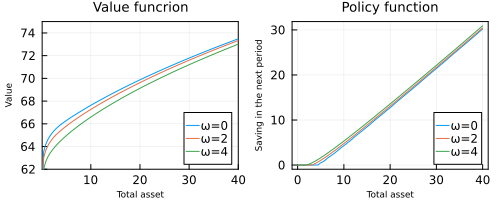

In [5]:
p1 = plot(legend_position=:bottomright, xlims=(10^-1,40), ylims=(62,75))
xlabel!("Total asset")
ylabel!("Value")
p2 = plot(legend_position=:bottomright)
xlabel!("Total asset")
ylabel!("Saving in the next period")
for ω in [0, 2, 4]
    a, b = ab_LogNormal(4, ω)
    ξ = LogNormal(a, b)
    Value_funcrion, Policy_function =VFIWS(U, h, β, Γ, Range, l, IG, ξ)
    plot!(p1, range(Range[1], Range[2], l), Value_funcrion, title = "Value funcrion", label="ω=$(ω)", titlefontsize=9, guidefontsize=6)
    plot!(p2, range(Range[1], Range[2], l), Policy_function, title = "Policy function", label="ω=$(ω)", titlefontsize=9, guidefontsize=6)
end
plots = []
push!(plots,p1)
push!(plots,p2)
plot(plots..., framestyle = :box, size = (500, 200))